# Pozo SMO2 Humid Points EDA

__Author:__ Pat McCornack

__Date:__ 09/30/24

__Purpose:__ Investigate the distributions of variables when the data is subset to observations with very high humidity.



In [7]:
import os

import pandas as pd
import numpy as np
import datetime as dict

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Functions
----

In [8]:
# Check dew point

def calc_dew_point(temp_series, rh_series):
    b = 17.625
    c = 243.04

    dew_point = []
    for i in range(len(temp_series)):
        gamma = np.log((rh_series.iloc[i]/100)) + (b*temp_series.iloc[i])/(c+temp_series.iloc[i])
        dp = (c * gamma) / (b - gamma)

        dew_point.append(dp)

    return dew_point

# Main
----

In [9]:
#### Read in and Prepare Data ####
df_path = "/Users/patmccornack/Documents/ucsb_fog_project/data/csv/SCI_POZO_SM02.csv"
df_og = pd.read_csv(df_path)

col_names = ['time', 'fog', 'RH', 'rad', 'air_temp_avg', 'air_temp_min', 'atm_pressure',
             'soil_water_potential', 'soil_moisture', 'soil_temp_10cm', 
             'leaf_wetness', 'rainfall', 'vapor_pressure', 'wind_dir', 'wind_speed']

df_og = df_og[['time', 'fog-harp-ml', 'relative-humidity-minimum-rh-min-pct',
       'solar-radiation-average-slr-flux-k-w-avg-kwm-2',
       'air-temperature-average-degc', 'air-temperature-minimum-degc',
       'barometric-pressure-average-bp-mbar-avg-mb',
       'soil-water-potential-average-matrix-potential-100-avg-kpa',
       'soil-moisture-average-vwc-100-soil-avg',
       'soil-temperature-10-cm-average-degc',
       'leaf-wetness-average-l-wm-v-avg-mv',
       'rainfall-sum-rain-mm-tot-mm',
       'barometric-pressure-average-vp-mbar-avg-mb',
       'air-temperature-wind-vector-cells-wind-dir-du-wvt-deg',
       'wind-speed-wind-vector-cells-ws-ms-u-wvt-ms']]

df_og.columns = col_names

# Check NA and drop
print(f"NA Counts: \n{df_og.isna().sum()}")
df_og.dropna(inplace=True)

# Drop observations
df_og = df_og.drop(df_og.loc[df_og['RH'] == 0].index)  # 3 observations, improbable to have 0% RH and fog


# Derived variables

## Create variable for presence of rain/fog/both
df_og['condition'] = 'dry'
for index, row in df_og.iterrows():
    condition='dry'
    if row['fog'] > 0:
        df_og.loc[index, 'condition'] = 'fog'

    if row['rainfall'] > 0:
        df_og.loc[index, 'condition'] = 'rain'
    
    if (row['rainfall'] > 0) & (row['fog'] > 0):
        df_og.loc[index, 'condition'] = 'both'

## Create dewpoint temperature variable
df_og['dew_point'] = calc_dew_point(df_og['air_temp_min'], df_og['RH'])


## Difference between air temp and dew point 
df_og['dew_point_depression'] = df_og['air_temp_min'] - df_og['dew_point']

## Difference between air temp and soil temp
df_og['air_soil_temp_diff'] = df_og['air_temp_min'] - df_og['soil_temp_10cm']

NA Counts: 
time                      0
fog                     207
RH                        0
rad                       0
air_temp_avg              0
air_temp_min              0
atm_pressure              0
soil_water_potential      0
soil_moisture             0
soil_temp_10cm            0
leaf_wetness              0
rainfall                  0
vapor_pressure            0
wind_dir                  0
wind_speed                0
dtype: int64


## Dew Point Distribution
Check the distributions of the dew point, RH, and dew point depression. 

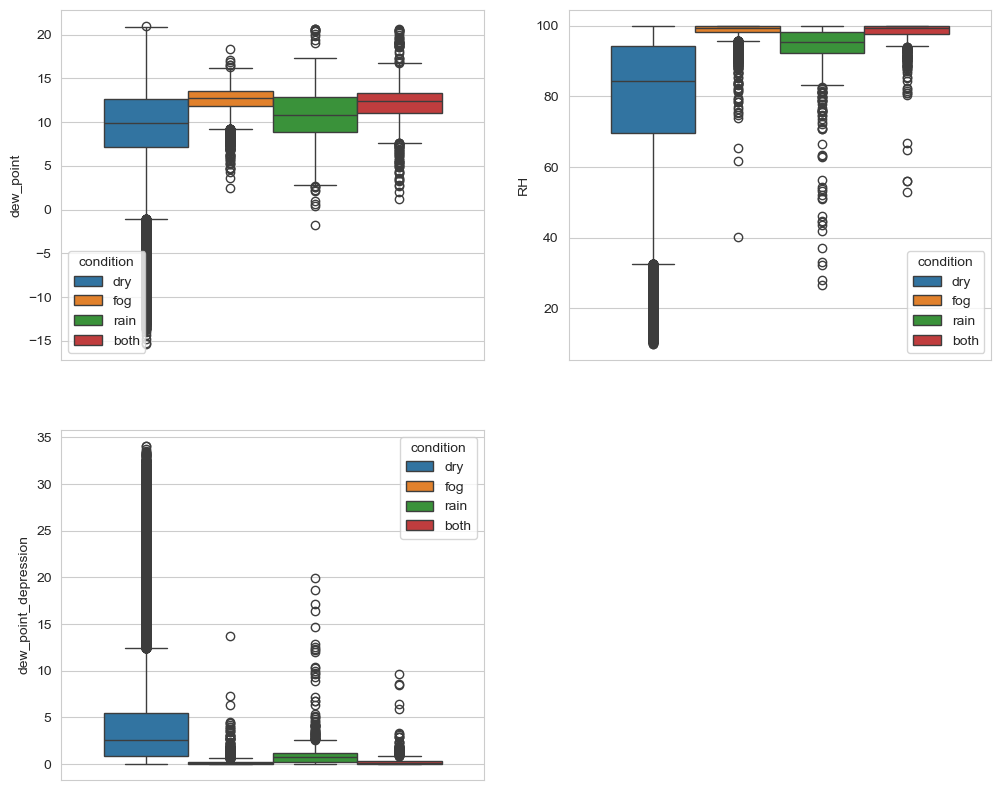

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
sns.boxplot(data=df_og,
            y='dew_point',
            hue='condition',
            ax=ax[0][0])

sns.boxplot(data=df_og,
            y='RH',
            hue='condition',
            ax=ax[0][1])

sns.boxplot(data=df_og,
            y='dew_point_depression',
            hue='condition',
            ax=ax[1][0])

ax[1][1].set_visible(False)


plt.show()

## Subset to humid observations
We want to assess whether we can isolate fog events occurring during conditions favorable to fog, therefore we subset the data to times where the relative humidity is high (RH > 90%)

In [16]:
#### Subset data and check counts ####
# Subset to humid days
df_humid = df_og.loc[df_og['RH'] > 90]
print(f"Original: {df_og.shape}")
print(f"Humid Subset: {df_humid.shape}")
df_humid.describe()

# Create set of 100% RH observations
df_humid_100pct = df_og.loc[df_og['RH'] == 100]

Original: (74091, 19)
Humid Subset: (32546, 19)


In [17]:
#### Check point counts stratified by condition ####
print(f"Original Data: \n{df_og['condition'].value_counts()}\n")
print(f"Humid Subset: \n{df_humid['condition'].value_counts()}")

Original Data: 
condition
dry     65250
fog      5600
rain     1881
both     1360
Name: count, dtype: int64

Humid Subset: 
condition
dry     24028
fog      5540
rain     1650
both     1328
Name: count, dtype: int64


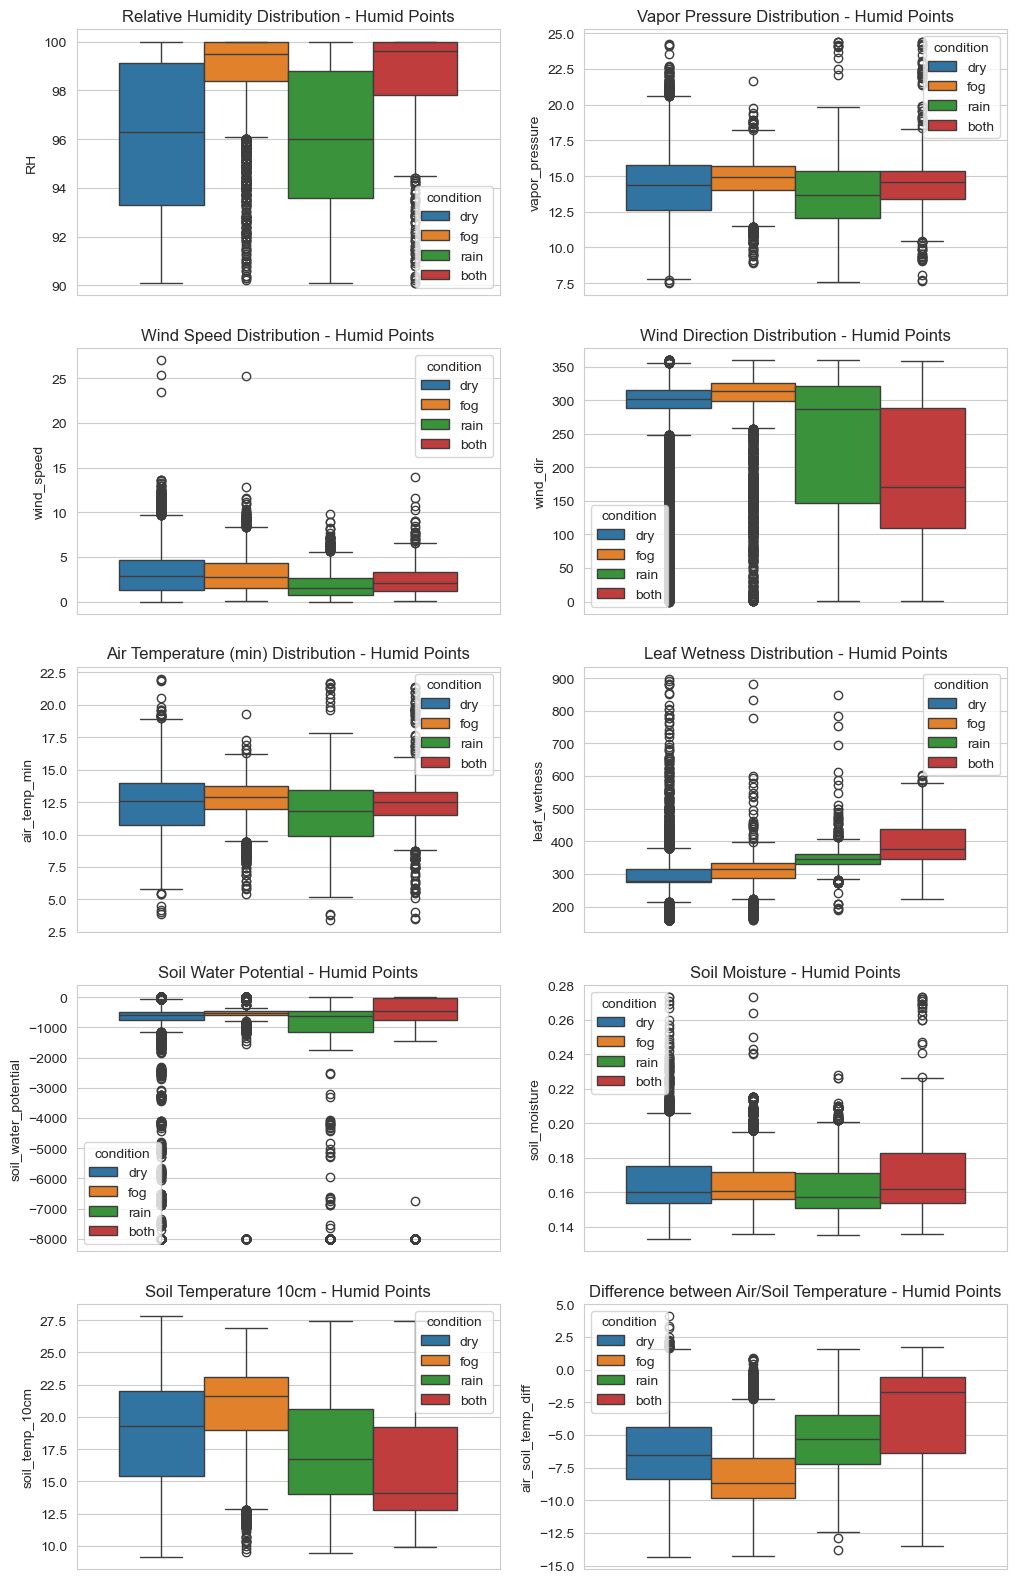

In [18]:
#### Boxplots for humid observations ####

fig, ax = plt.subplots(5, 2, figsize=(12, 20))

sns.boxplot(data=df_humid,
            y='RH',
            hue='condition',
            ax=ax[0][0])
sns.boxplot(data=df_humid,
            y='vapor_pressure',
            hue='condition',
            ax=ax[0][1])
sns.boxplot(data=df_humid,
            y='wind_speed',
            hue='condition',
            ax=ax[1][0])
sns.boxplot(data=df_humid,
            y='wind_dir',
            hue='condition',
            ax=ax[1][1])
sns.boxplot(data=df_humid,
            y='air_temp_min',
            hue='condition',
            ax=ax[2][0])
sns.boxplot(data=df_humid,
            y='leaf_wetness',
            hue='condition',
            ax=ax[2][1])
sns.boxplot(data=df_humid,
            y='soil_water_potential',
            hue='condition',
            ax=ax[3][0])
sns.boxplot(data=df_humid,
            y='soil_moisture',
            hue='condition',
            ax=ax[3][1])
sns.boxplot(data=df_humid,
            y='soil_temp_10cm',
            hue='condition',
            ax=ax[4][0])
sns.boxplot(data=df_humid,
            y='air_soil_temp_diff',
            hue='condition',
            ax=ax[4][1])


ax[0][0].set(title='Relative Humidity Distribution - Humid Points')
ax[0][1].set(title='Vapor Pressure Distribution - Humid Points')
ax[1][0].set(title='Wind Speed Distribution - Humid Points')
ax[1][1].set(title='Wind Direction Distribution - Humid Points')
ax[2][0].set(title='Air Temperature (min) Distribution - Humid Points')
ax[2][1].set(title='Leaf Wetness Distribution - Humid Points')
ax[3][0].set(title='Soil Water Potential - Humid Points')
ax[3][1].set(title='Soil Moisture - Humid Points')
ax[4][0].set(title='Soil Temperature 10cm - Humid Points')
ax[4][1].set(title='Difference between Air/Soil Temperature - Humid Points')

plt.show()

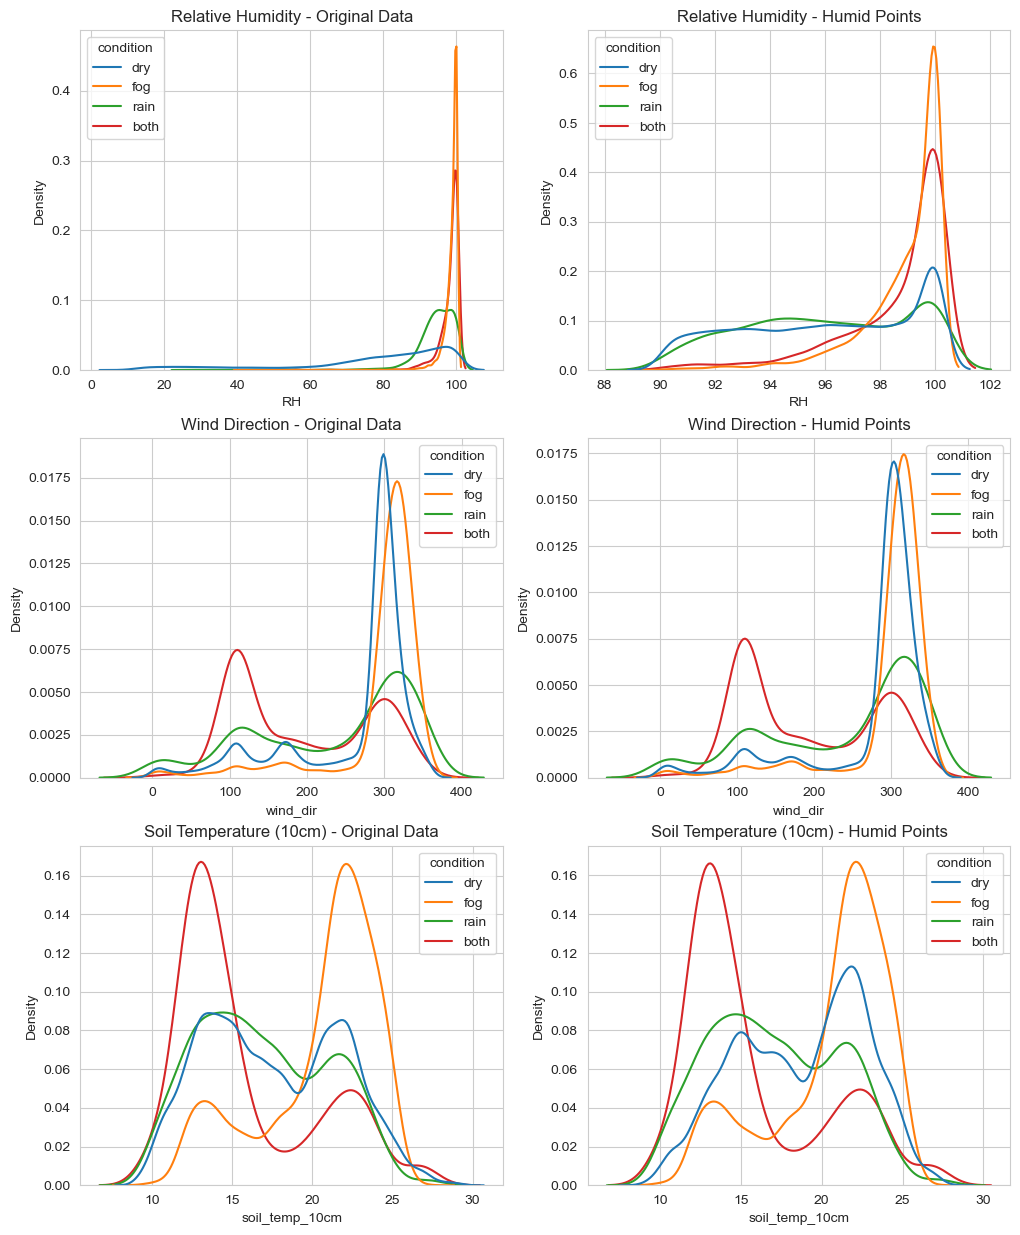

In [19]:
#### KDE plots for humid observations ####
fig, ax = plt.subplots(3,2, figsize=(12,15))

sns.kdeplot(data=df_og,
            x='RH',
            hue='condition',
            common_norm=False,
            ax=ax[0][0])
sns.kdeplot(data=df_humid,
            x='RH',
            hue='condition',
            common_norm=False,
            ax=ax[0][1])

sns.kdeplot(data=df_og,
            x='wind_dir',
            hue='condition',
            common_norm=False,
            ax=ax[1][0])
sns.kdeplot(data=df_humid,
            x='wind_dir',
            hue='condition',
            common_norm=False,
            ax=ax[1][1])

sns.kdeplot(data=df_og,
            x='soil_temp_10cm',
            hue='condition',
            common_norm=False,
            ax=ax[2][0])
sns.kdeplot(data=df_humid,
            x='soil_temp_10cm',
            hue='condition',
            common_norm=False,
            ax=ax[2][1])

ax[0][0].set(title='Relative Humidity - Original Data')
ax[0][1].set(title='Relative Humidity - Humid Points')

ax[1][0].set(title='Wind Direction - Original Data')
ax[1][1].set(title='Wind Direction - Humid Points')

ax[2][0].set(title='Soil Temperature (10cm) - Original Data')
ax[2][1].set(title='Soil Temperature (10cm) - Humid Points')

plt.show()

[Text(0.5, 1.0, 'KDE - Wind Direction vs. Relative Humidity')]

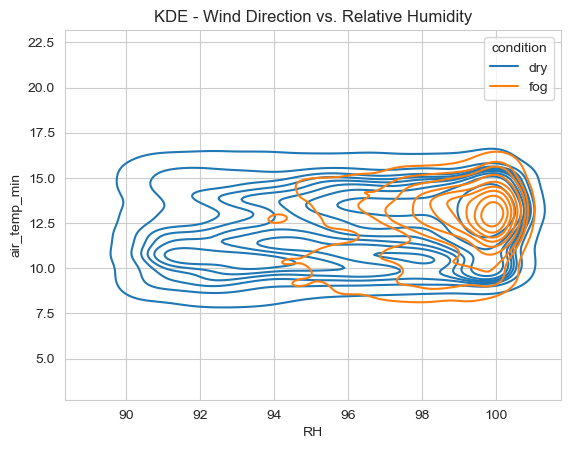

In [49]:
#### Bivariate KDE Plot ####
ax = sns.kdeplot(data=df_humid.loc[df_humid['condition'].isin(['dry','fog'])],
                 x='RH', 
                 y='air_temp_min',
                 hue='condition',
                 common_norm=False)
ax.set(title='KDE - Wind Direction vs. Relative Humidity')
#ax.set_ylim(0,10)

## 100% Humidity
Subset to only points with 100% RH. Check what the distribution of atmospheric conditions is within those points compared to the full dataset, then check variable distributions for these observations. 

(7092, 19)


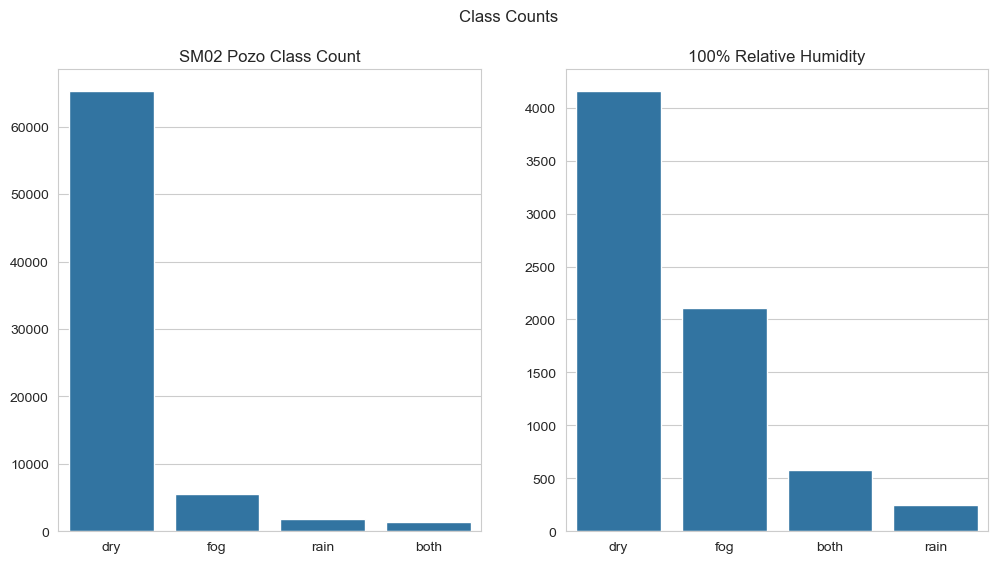

In [20]:
#### Class Counts of 100% RH observations vs. full dataset ####
print(df_humid_100pct.shape)

fig, ax = plt.subplots(1,2, figsize=(12,6))
counts_RH100pct = df_humid_100pct['condition'].value_counts().to_dict()
counts_og = df_og['condition'].value_counts().to_dict()

sns.barplot(data=counts_og,
            ax=ax[0])
sns.barplot(data=counts_RH100pct,
            ax=ax[1])


plt.suptitle("Class Counts")
ax[0].set(title="SM02 Pozo Class Count")
ax[1].set(title='100% Relative Humidity')

plt.show()


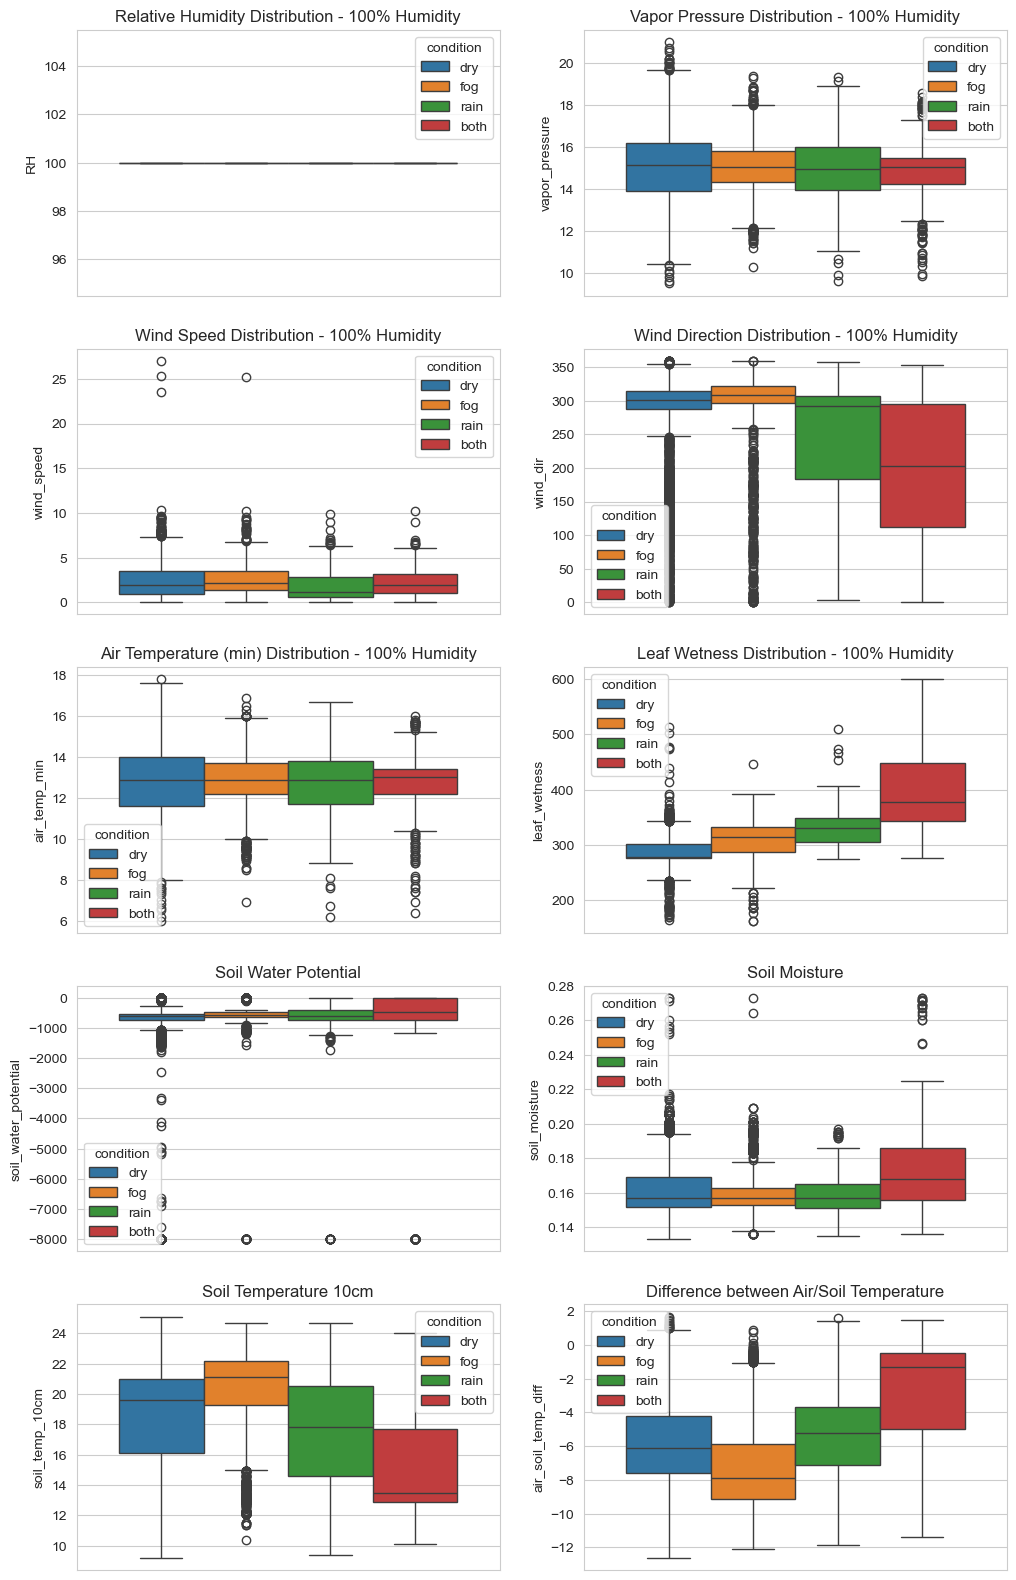

In [27]:
#### Boxplots for 100% RH observations #### 

fig, ax = plt.subplots(5, 2, figsize=(12, 20))

sns.boxplot(data=df_humid_100pct,
            y='RH',
            hue='condition',
            ax=ax[0][0])
sns.boxplot(data=df_humid_100pct,
            y='vapor_pressure',
            hue='condition',
            ax=ax[0][1])
sns.boxplot(data=df_humid_100pct,
            y='wind_speed',
            hue='condition',
            ax=ax[1][0])
sns.boxplot(data=df_humid_100pct,
            y='wind_dir',
            hue='condition',
            ax=ax[1][1])
sns.boxplot(data=df_humid_100pct,
            y='air_temp_min',
            hue='condition',
            ax=ax[2][0])
sns.boxplot(data=df_humid_100pct,
            y='leaf_wetness',
            hue='condition',
            ax=ax[2][1])
sns.boxplot(data=df_humid_100pct,
            y='soil_water_potential',
            hue='condition',
            ax=ax[3][0])
sns.boxplot(data=df_humid_100pct,
            y='soil_moisture',
            hue='condition',
            ax=ax[3][1])
sns.boxplot(data=df_humid_100pct,
            y='soil_temp_10cm',
            hue='condition',
            ax=ax[4][0])
sns.boxplot(data=df_humid_100pct,
            y='air_soil_temp_diff',
            hue='condition',
            ax=ax[4][1])


ax[0][0].set(title='Relative Humidity Distribution - 100% Humidity')
ax[0][1].set(title='Vapor Pressure Distribution - 100% Humidity')
ax[1][0].set(title='Wind Speed Distribution - 100% Humidity')
ax[1][1].set(title='Wind Direction Distribution - 100% Humidity')
ax[2][0].set(title='Air Temperature (min) Distribution - 100% Humidity')
ax[2][1].set(title='Leaf Wetness Distribution - 100% Humidity')
ax[3][0].set(title='Soil Water Potential')
ax[3][1].set(title='Soil Moisture')
ax[4][0].set(title='Soil Temperature 10cm')
ax[4][1].set(title='Difference between Air/Soil Temperature')

plt.show()

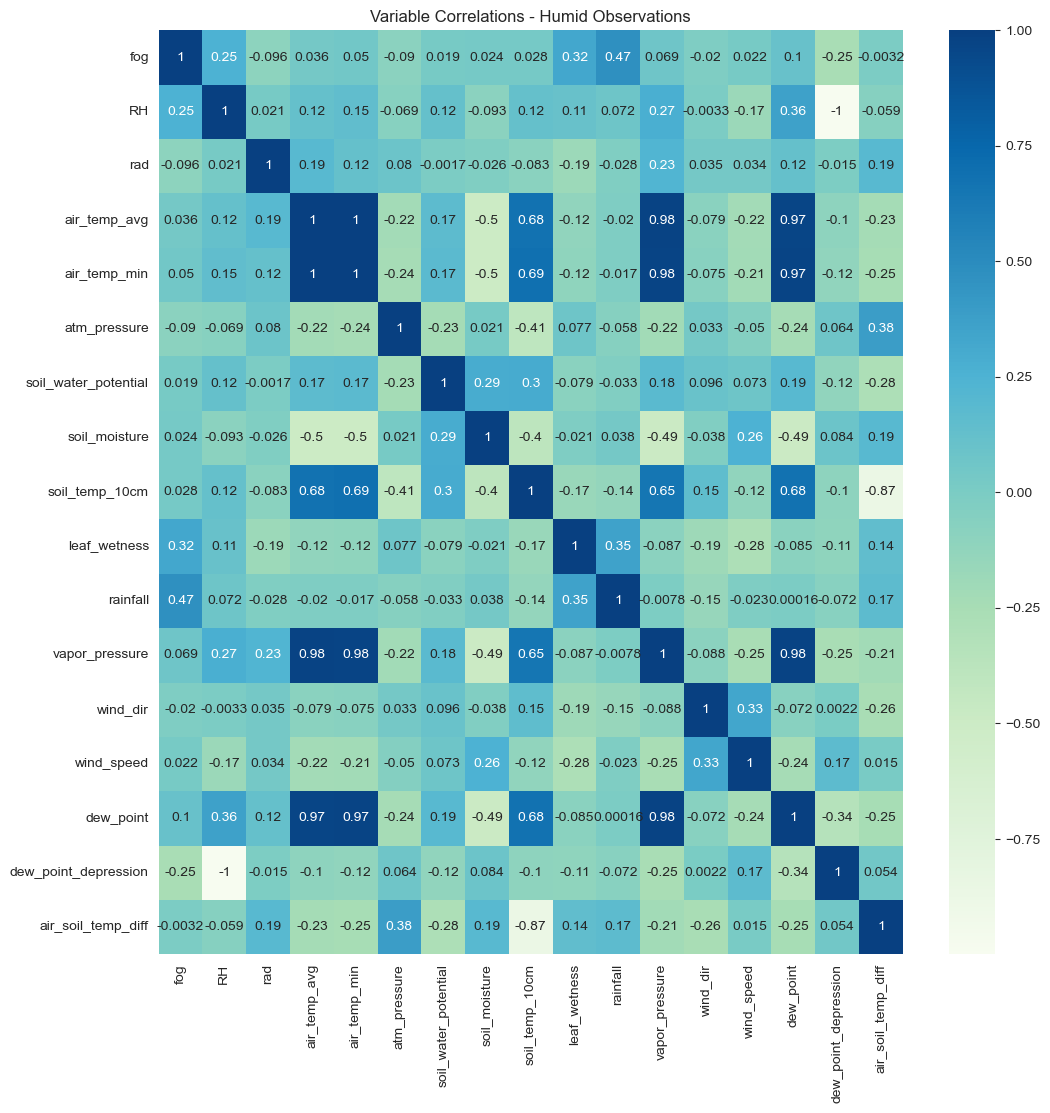

In [21]:
#### Linear correlations for 100% RH observations ####
corr_df = df_humid.drop(['time', 'condition'], axis=1).corr()
plt.figure(figsize=(12,12))
ax = sns.heatmap(corr_df, annot=True, cmap='GnBu')
ax.set_title('Variable Correlations - Humid Observations')
plt.show()